# Ferry Classification Model (Crepe + STFT)
#### Binary Classifier 
Last Updated December 5, 2019

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pywt
from matplotlib.image import imread
import numpy as np
import os
from scipy.io import wavfile
from pathlib import Path
import pywt
import soundfile
import random
import pickle
from glob import iglob
import crepe
from sklearn.metrics import confusion_matrix, classification_report
import pprint
random.seed(42)
import librosa
import scipy.signal
from keras.layers import MaxPooling2D, Flatten, Conv2D
from keras.utils import to_categorical
import keras
from keras.layers import initializers 
from keras.layers import regularizers 
from keras.layers import constraints 
from keras.layers import Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
from keras.constraints import max_norm
from keras.layers import LeakyReLU
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from keras.layers import MaxPooling3D, Flatten, Conv3D
from keras import backend as K
from keras.layers import LeakyReLU,PReLU
import keras
from keras.losses import *
def my_init(shape,  dtype=None):
    vals=((float(shape[0], float(shape[1]))) * math.sqrt(2./float(shape[1])))
    return K.random_normal(vals, dtype=dtype)    
import math
from pydub import AudioSegment
from pydub.playback import play
import specAugment

import tkinter
from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
# Implement the default Matplotlib key bindings.
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure
import nlpaug
import nlpaug.augmenter.spectrogram as nas
import nlpaug.flow 
import nlpaug.flow as naf

from nlpaug.util.file.load import LoadUtil
from nlpaug.util.visual.spectrogram import VisualSpectrogram

from scipy.signal import resample

Using TensorFlow backend.
C:\Anaconda\envs\amlrealtimeai\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda\envs\amlrealtimeai\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda\envs\amlrealtimeai\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda\envs\amlrealtimeai\lib\site-packages\tensorflow\py

The Puyallip


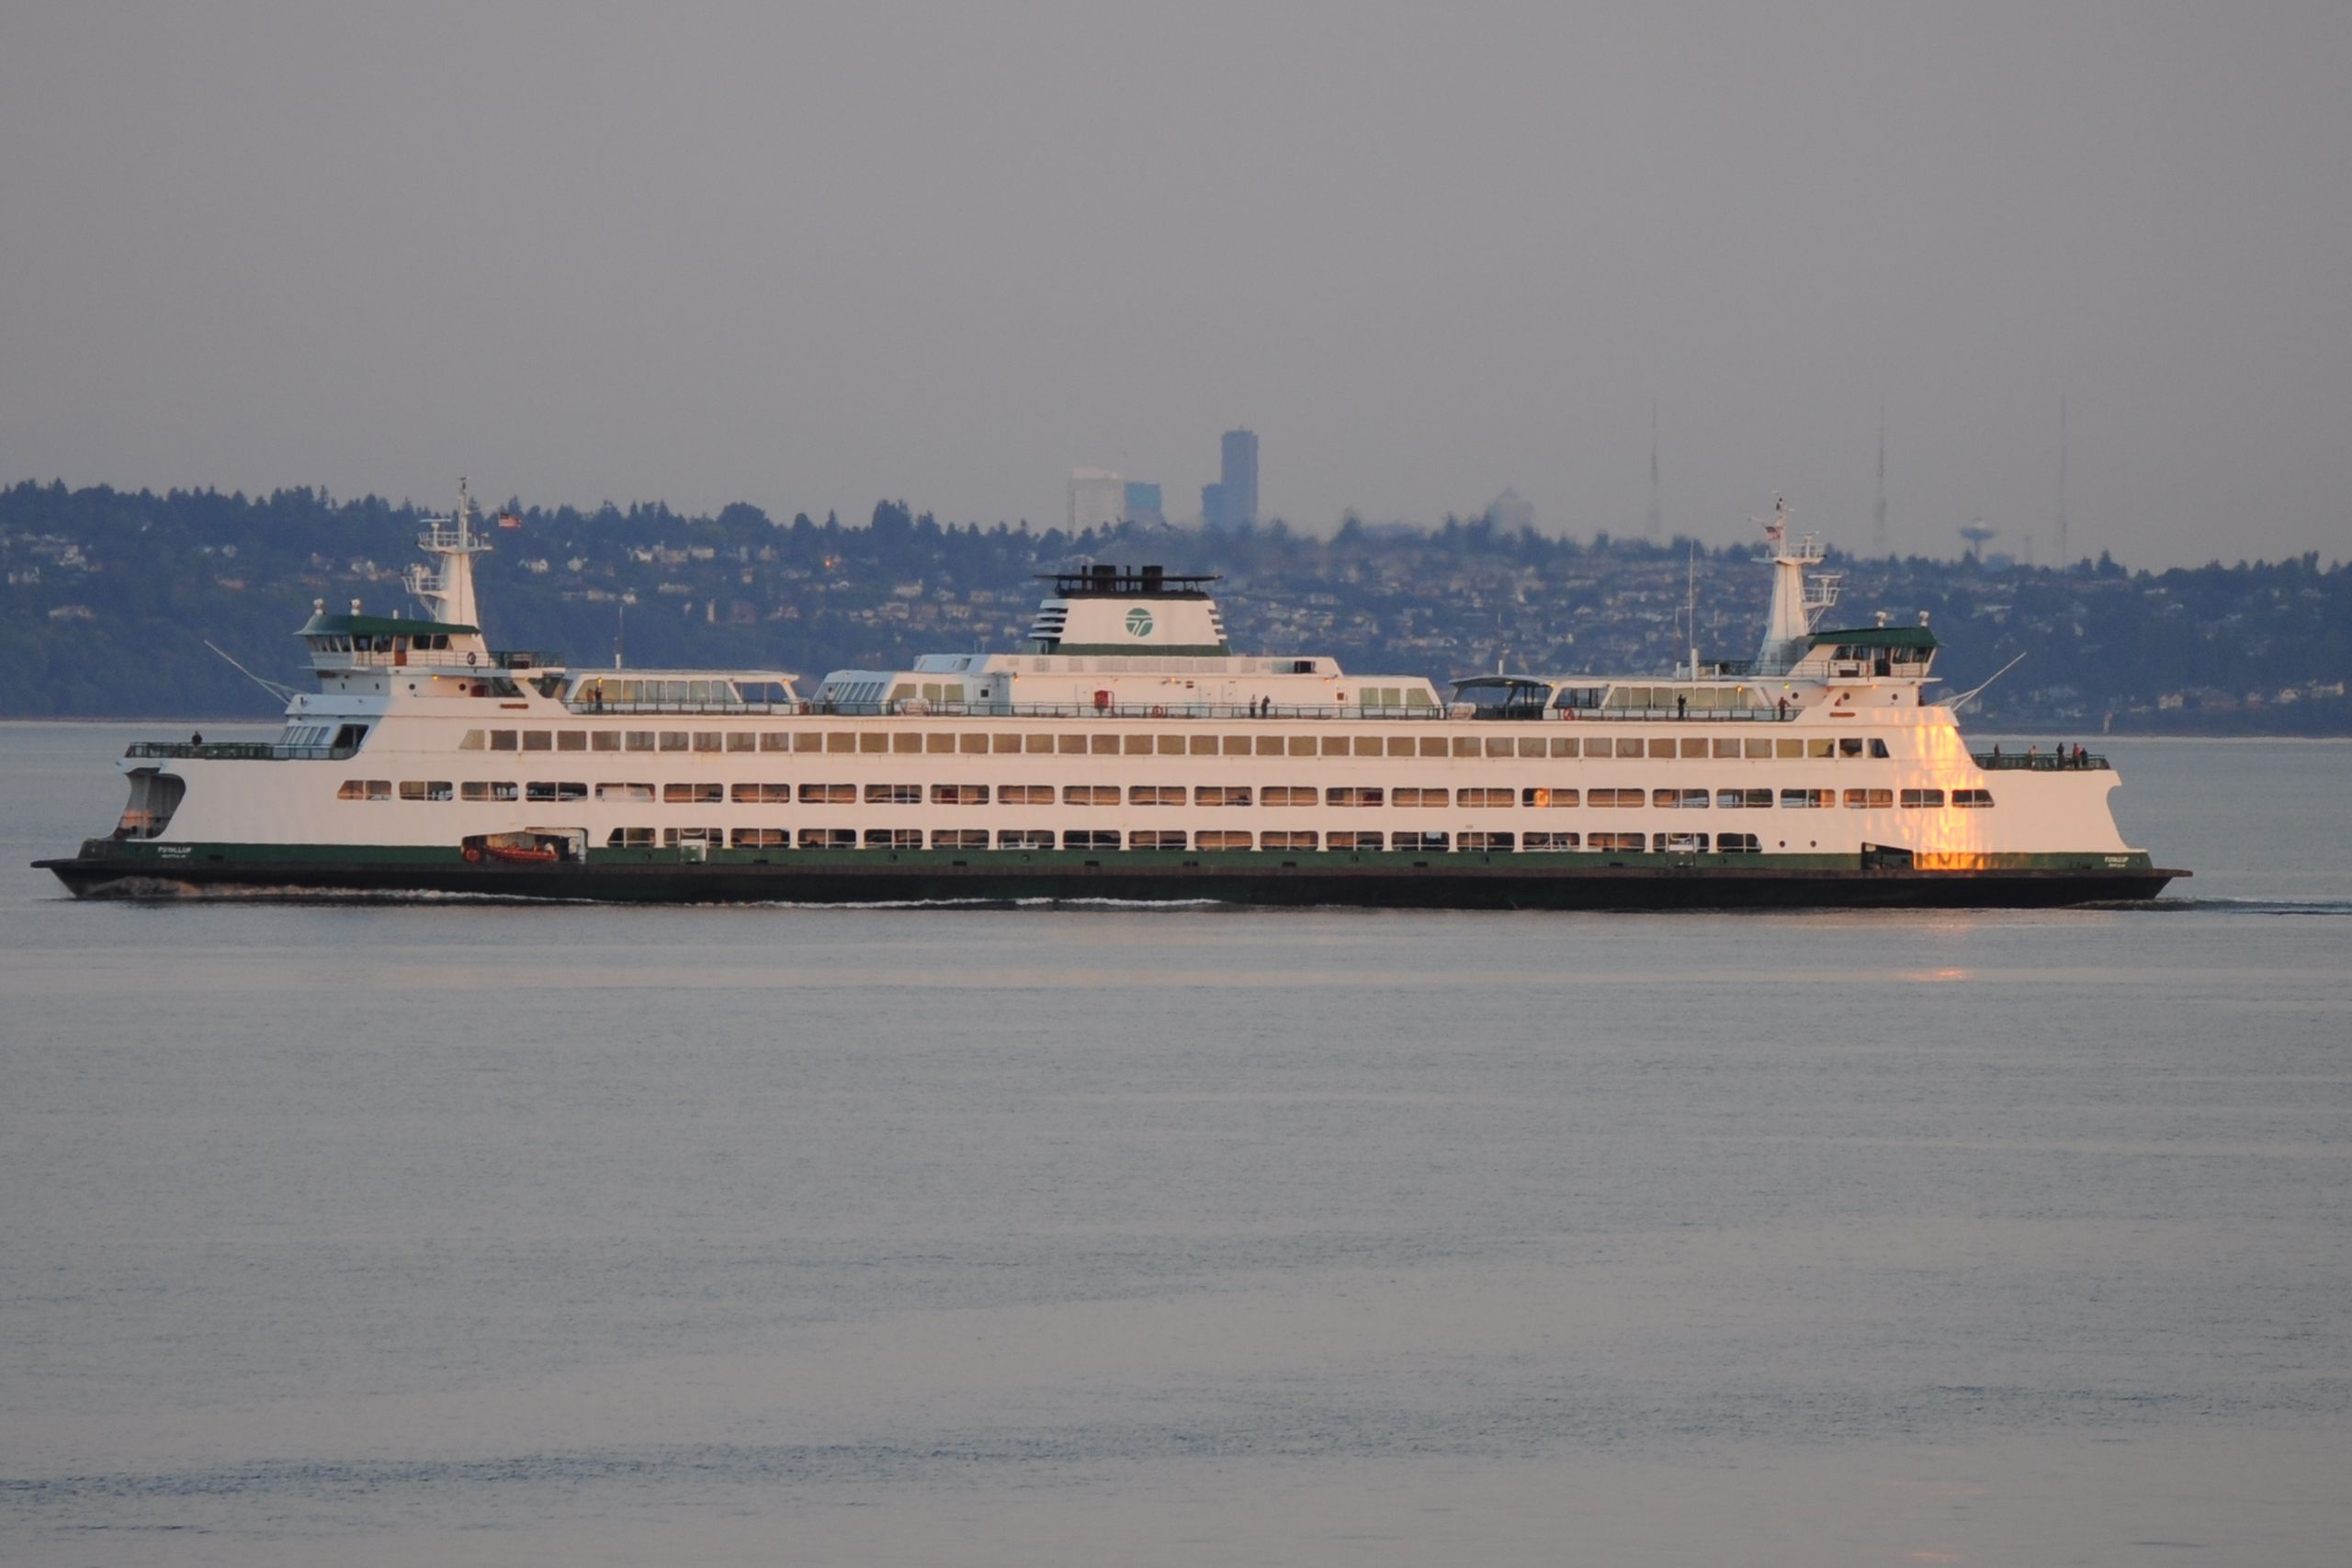

In [2]:
os.chdir("D:\\ferry")
import IPython
from IPython.display import Image, Audio
print("The Puyallip")
Image(filename='puyallip_photo.jpg',width=300, height=200)

In [3]:
fs, audio_sample = wavfile.read("wenatchee.wav")
IPython.display.Audio(audio_sample, rate=32000)

The Tacomoa


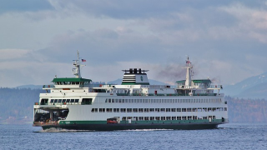

In [4]:
print("The Tacomoa")
Image(filename='tacoma.png',width=300, height=200)

In [5]:
fs, audio_sample = wavfile.read("tacoma.wav")
IPython.display.Audio(audio_sample, rate=32000)

In [6]:
os.chdir('D://ferry//local-data')
print(os.getcwd())

Train_Tacoma_matrix = np.loadtxt('Train_Tacoma_matrix.txt', delimiter=',')
Train_Puyallip_matrix = np.loadtxt('Train_Puyallip_matrix.txt', delimiter=',')

Test_Tacoma_matrix = np.loadtxt('Test_Tacoma_matrix.txt', delimiter=',')
Test_Puyallip_matrix = np.loadtxt('Test_Puyallip_matrix.txt', delimiter=',')




D:\ferry\local-data


C:\Users\pattyry\AppData\Roaming\Python\Python36\site-packages\scipy\sparse\lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


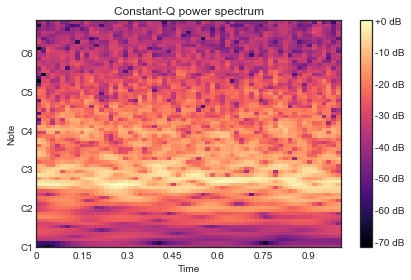

In [7]:
import librosa.display
import matplotlib.pyplot as plt
C = np.abs(librosa.cqt(Test_Puyallip_matrix[60,:], sr=32000, fmin=librosa.note_to_hz('C1'), n_bins=70, bins_per_octave=12))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=32000, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

[-5348. -5561. -5703. ...   354.   560.   698.]


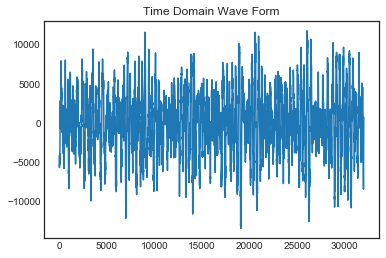

In [8]:
signal = Test_Tacoma_matrix[40,:]
time = 32000
print(signal)
plt.plot(signal)
plt.title('Time Domain Wave Form')
plt.show()

### Add Augmented Data

In [9]:
def _create_augmented_volume_reduction_data_matrix(old_matrix, volume_change):
    
    old_matrix = np.asarray(old_matrix)
    new_target_numpy = np.empty((32000),int)
    new_target_numpy = np.asarray(new_target_numpy)    

    for i in range(old_matrix.shape[0]):
        new_numpy = old_matrix[i,:] + volume_change
        new_numpy = np.asarray(new_numpy)
        new_target_numpy = np.vstack((new_target_numpy, new_numpy))
        new_target_numpy = np.asarray(new_target_numpy)
    return(new_target_numpy)

In [10]:
# Create Augmented matrices with volume reduction
Augmented_Train_Tacoma_matrix = _create_augmented_volume_reduction_data_matrix(Train_Tacoma_matrix, -5)
Augmented_Train_Puyallip_matrix = _create_augmented_volume_reduction_data_matrix(Train_Puyallip_matrix, -5)
Augmented_Test_Tacoma_matrix = _create_augmented_volume_reduction_data_matrix(Test_Tacoma_matrix, -5)
Augmented_Test_Puyallip_matrix= _create_augmented_volume_reduction_data_matrix(Test_Puyallip_matrix, -5)

In [11]:
def _create_augmented_white_noise_data_matrix(old_matrix, noise_level):
    new_target_numpy = np.empty((32000),int)
    new_target_numpy = np.asarray(new_target_numpy)   
    
    for i in range(old_matrix.shape[0]):
        wn = np.random.randn(old_matrix.shape[1])
        new_numpy = old_matrix[i,:] + noise_level*wn
        new_numpy = np.asarray(new_numpy)
        new_target_numpy = np.vstack((new_target_numpy, new_numpy))
        new_target_numpy = np.asarray(new_target_numpy)
    return(new_target_numpy)

In [12]:
# Create Augmented matrices with white noise added



Augmented_Train_Tacoma_matrix2= _create_augmented_white_noise_data_matrix(Train_Tacoma_matrix,0.01)
Augmented_Train_Puyallip_matrix2 = _create_augmented_white_noise_data_matrix(Train_Puyallip_matrix,0.01)
Augmented_Test_Tacoma_matrix2 = _create_augmented_white_noise_data_matrix(Test_Tacoma_matrix,0.01)
Augmented_Test_Puyallip_matrix2 = _create_augmented_white_noise_data_matrix(Test_Puyallip_matrix,0.01)

### Add Labels

In [13]:
Train_Tacoma_matrix = np.c_[ np.ones(len(Train_Tacoma_matrix)),Train_Tacoma_matrix] 
Train_Tacoma_matrix[:, 0] =  0
print(Train_Tacoma_matrix.shape)

Train_Puyallip_matrix = np.c_[ np.ones(len(Train_Puyallip_matrix)),Train_Puyallip_matrix] 
Train_Puyallip_matrix[:, 0] =  1
print(Train_Puyallip_matrix.shape)


(640, 32001)
(398, 32001)


In [14]:
# Add labels to source matrices


Test_Tacoma_matrix = np.c_[ np.ones(len(Test_Tacoma_matrix)),Test_Tacoma_matrix] 
Test_Tacoma_matrix[:, 0] = 0 
print(Test_Tacoma_matrix.shape)

Test_Puyallip_matrix = np.c_[ np.ones(len(Test_Puyallip_matrix)),Test_Puyallip_matrix] 
Test_Puyallip_matrix[:, 0] =  1
print(Test_Puyallip_matrix.shape)


(114, 32001)
(90, 32001)


In [15]:
#Add labels to augmented Matrices
# Volume reduction


Augmented_Train_Tacoma_matrix = np.c_[ np.ones(len(Augmented_Train_Tacoma_matrix)),Augmented_Train_Tacoma_matrix] 
Augmented_Train_Tacoma_matrix[:, 0] = 0
Augmented_Train_Tacoma_matrix = np.delete(Augmented_Train_Tacoma_matrix, (0), axis=0)
print(Augmented_Train_Tacoma_matrix.shape)

Augmented_Train_Puyallip_matrix = np.c_[ np.ones(len(Augmented_Train_Puyallip_matrix)),Augmented_Train_Puyallip_matrix] 
Augmented_Train_Puyallip_matrix[:, 0] = 1
Augmented_Train_Puyallip_matrix = np.delete(Augmented_Train_Puyallip_matrix, (0), axis=0)
print(Augmented_Train_Puyallip_matrix.shape)

Augmented_Test_Tacoma_matrix = np.c_[ np.ones(len(Augmented_Test_Tacoma_matrix)),Augmented_Test_Tacoma_matrix] 
Augmented_Test_Tacoma_matrix[:, 0] =0
Augmented_Test_Tacoma_matrix = np.delete(Augmented_Test_Tacoma_matrix, (0), axis=0)
print(Augmented_Test_Tacoma_matrix.shape)

Augmented_Test_Puyallip_matrix = np.c_[ np.ones(len(Augmented_Test_Puyallip_matrix)),Augmented_Test_Puyallip_matrix] 
Augmented_Test_Puyallip_matrix[:, 0] = 1
Augmented_Test_Puyallip_matrix = np.delete(Augmented_Test_Puyallip_matrix, (0), axis=0)
print(Augmented_Test_Puyallip_matrix.shape)




(640, 32001)
(398, 32001)
(114, 32001)
(90, 32001)


In [16]:
# Noise addition

Augmented_Train_Tacoma_matrix2 = np.c_[ np.ones(len(Augmented_Train_Tacoma_matrix2)),Augmented_Train_Tacoma_matrix2] 
Augmented_Train_Tacoma_matrix2[:, 0] = 0
Augmented_Train_Tacoma_matrix2 = np.delete(Augmented_Train_Tacoma_matrix2, (0), axis=0)
print(Augmented_Train_Tacoma_matrix2.shape)

Augmented_Train_Puyallip_matrix2 = np.c_[ np.ones(len(Augmented_Train_Puyallip_matrix2)),Augmented_Train_Puyallip_matrix2] 
Augmented_Train_Puyallip_matrix2[:, 0] = 1
Augmented_Train_Puyallip_matrix2 = np.delete(Augmented_Train_Puyallip_matrix2, (0), axis=0)
print(Augmented_Train_Puyallip_matrix2.shape)

Augmented_Test_Tacoma_matrix2 = np.c_[ np.ones(len(Augmented_Test_Tacoma_matrix2)),Augmented_Test_Tacoma_matrix2] 
Augmented_Test_Tacoma_matrix2[:, 0] =0
Augmented_Test_Tacoma_matrix2 = np.delete(Augmented_Test_Tacoma_matrix2, (0), axis=0)
print(Augmented_Test_Tacoma_matrix2.shape)

Augmented_Test_Puyallip_matrix2 = np.c_[ np.ones(len(Augmented_Test_Puyallip_matrix2)),Augmented_Test_Puyallip_matrix2] 
Augmented_Test_Puyallip_matrix2[:, 0] = 1
Augmented_Test_Puyallip_matrix2 = np.delete(Augmented_Test_Puyallip_matrix2, (0), axis=0)
print(Augmented_Test_Puyallip_matrix2.shape)


(640, 32001)
(398, 32001)
(114, 32001)
(90, 32001)


### Split and Shuffle Data

In [17]:
all_train_data = []
all_test_data = []

In [18]:
all_train_data = np.append(Train_Tacoma_matrix, Train_Puyallip_matrix, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_Puyallip_matrix, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_Puyallip_matrix2, axis=0)
print(all_train_data.shape)

all_train_data = np.append(all_train_data, Augmented_Train_Tacoma_matrix, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_Tacoma_matrix2, axis=0)
print(all_train_data.shape)

(1038, 32001)
(1436, 32001)
(1834, 32001)
(2474, 32001)
(3114, 32001)


In [19]:
all_test_data = np.append(Test_Tacoma_matrix, Test_Puyallip_matrix, axis=0)
print(all_test_data.shape)


(204, 32001)


In [20]:
type(all_train_data)

numpy.ndarray

In [21]:
# Shuffle rows
np.random.shuffle(all_train_data)
np.random.shuffle(all_test_data)

# Seperate Labelinto y
y_train = np.asarray(all_train_data[:,0])
y_test = np.asarray(all_test_data[:,0])

#Seperate data into x
X_train = np.asarray(all_train_data[:,1:32001])
X_test = np.asarray(all_test_data[:,1:32001])

In [22]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(3114,)
(3114, 32000)
(204,)
(204, 32000)


### Save Intermediary Files

In [23]:
y_train = np.asarray(y_train)
X_train = np.asarray(X_train)
y_test = np.asarray(y_test)
X_test = np.asarray(X_test)

In [24]:
# Eliminate any rows that are all nulls
X_test_nulls = np.where(~X_test.any(axis=1))[0]
X_train_nulls = np.where(~X_train.any(axis=1))[0]

print(X_test_nulls.shape)
print(X_train_nulls.shape)

(0,)
(0,)


### Featurizing

In [25]:
# Function to convert audio from integer to float range
def convert_audio_i2f(audio):
    audio = audio.astype(np.float32, order='C') / 32000.0
    return audio

In [26]:
# Function to replace outliers
def replace_outliers(data_in, para=1.5):
    median = np.median(data_in)
    for val in range(0, len(data_in)):
        if (abs(data_in[val] - median)) >= (
                para * np.std(data_in)):  # std dev used of fund frequency for this class
            data_in[val] = median

    return data_in

In [27]:
# Function to generate fundamental frequencies from audio sample
def fundamental_freq_gen(y):
    y = np.array(y).astype(np.float)
    sr = float(32000)
    # Predict fundamental frequency based on crepe pre-trained pitch model
    _, frequency, _, _ = crepe.predict(y,
                                       sr,
                                       viterbi=False,
                                       verbose=0, step_size=10,
                                       model_capacity="full")
    frequency = np.array(frequency)    
    # Reshape for one prediction
    frequency = frequency.reshape(1, -1)
    return frequency

In [28]:

# Function to generate constant q and fundamental frequency features for each audio sample.
def _generate_features(data):
    allfreqs = []
    primary_input = []
    crepe_input = []
    labels = []
    data = np.asarray(data)
    data = data.astype(float)
    row_count = len(data)
    print(row_count)
    for x in range(0, row_count):
        raw_data = np.asarray(data[x,])
        crepe_data = np.asarray(data[x,])

        # Change sr from 32000 Hz to 22050 Hz to work with default librosa n_fft=2048
        stft_raw = resample(data[x,:], 22050)
        stft_raw = np.asfortranarray(stft_raw)
        stft_data = np.abs(librosa.stft(stft_raw))
        stft_data /= 255.0
        stft_shape_1 = stft_data.shape[1]
        stft_shape_0 = stft_data.shape[0]
        primary_input.append(stft_data)
        
    primary_input = np.array(primary_input).reshape(-1, stft_shape_0, stft_shape_1, 1)
    print('primary_input.shape:')
    print(primary_input.shape)

    for row in range(0,row_count):
        freq = fundamental_freq_gen(data[row,:])
        freq = np.array(freq)
        allfreqs.append(freq)
        crepe_input = np.array(allfreqs)

    print('crepe_input.shape:')
    print(crepe_input.shape)
    print(row_count)
    crepe_input= crepe_input.reshape(row_count, crepe_input.shape[2])
    #normalized_crepe_input = np.array([replace_outliers(x) for x in crepe_input])
    crepe_input = np.float32(crepe_input)
    print(crepe_input.shape)
    return primary_input, crepe_input

In [29]:
def _create_masked_spec(data, mask_freq_factor, mask_time_1, mask_time_2):

    flow = naf.Sequential([
        nas.FrequencyMaskingAug(mask_factor=mask_freq_factor), 
        nas.TimeMaskingAug(mask_factor=mask_time_1), 
        nas.TimeMaskingAug(mask_factor=mask_time_2)])
    primary_input = []
    data = np.asarray(data)
    data = data.astype(float)
    row_count = len(data)

    for x in range(0, row_count):
        raw_data = np.asarray(data[x,])
        # Downsample
        stft_raw = resample(data[x,:], 22050//8)
        stft_raw = np.asfortranarray(stft_raw)
        
        stft_data = np.abs(librosa.stft(y=stft_raw, n_fft=2048//12))
        

        stft_data /= 255.0
        stft_augmented_spectrogram = flow.augment(stft_data)
        stft_augmented_spectrogram_1 = stft_augmented_spectrogram.shape[1]
        stft_augmented_spectrogram_0 = stft_augmented_spectrogram.shape[0]
        primary_input.append(stft_augmented_spectrogram)
        
    primary_input = np.array(primary_input).reshape(-1, stft_augmented_spectrogram_0, stft_augmented_spectrogram_1, 1)
    print(VisualSpectrogram.visual('Frequency Masking', stft_augmented_spectrogram))
    
    
    return primary_input
        
# VisualSpectrogram.visual('Frequency Masking', augmented_mel_spectrogram)

3114


C:\Users\pattyry\AppData\Roaming\Python\Python36\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\pattyry\AppData\Roaming\Python\Python36\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\pattyry\AppData\Roaming\Python\Python36\site-packages\scipy\signal\signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. I

primary_input.shape:
(3114, 1025, 44, 1)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


C:\Anaconda\envs\amlrealtimeai\lib\site-packages\crepe\core.py:208: RuntimeWarning: invalid value encountered in true_divide
  frames /= np.std(frames, axis=1)[:, np.newaxis]


crepe_input.shape:
(3114, 1, 101)
3114
(3114, 101)


C:\Users\pattyry\AppData\Roaming\Python\Python36\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\pattyry\AppData\Roaming\Python\Python36\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\pattyry\AppData\Roaming\Python\Python36\site-packages\scipy\signal\signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. I

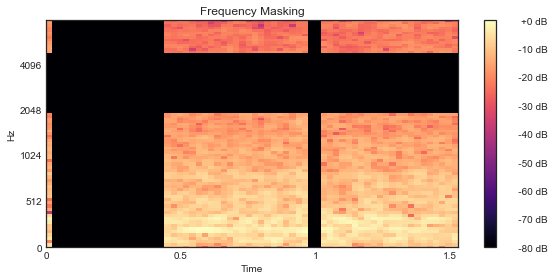

None


In [30]:
# Generate Training Features
train_stft_input, train_crepe_input = _generate_features(X_train)
train_aug_stft_input = _create_masked_spec(X_train, 30, 10, 20)

204
primary_input.shape:
(204, 1025, 44, 1)
crepe_input.shape:
(204, 1, 101)
204
(204, 101)


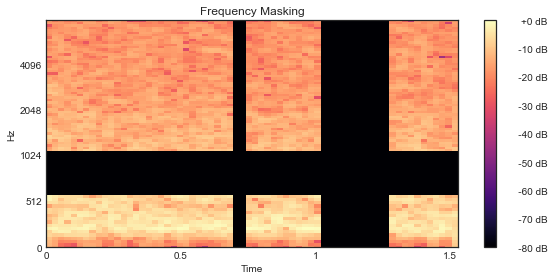

None


In [31]:
# Generate test features
test_stft_input, crepe_test_input = _generate_features(X_test)
test_aug_stft_input = _create_masked_spec(X_test, 30, 10, 20)

In [32]:
print('train input shapes')
print(train_stft_input.shape)
print(train_crepe_input.shape)
print(train_aug_stft_input.shape)
print('test input shapes')
print(test_stft_input.shape)
print(crepe_test_input.shape)
print(test_aug_stft_input.shape)

train input shapes
(3114, 1025, 44, 1)
(3114, 101)
(3114, 86, 66, 1)
test input shapes
(204, 1025, 44, 1)
(204, 101)
(204, 86, 66, 1)


In [33]:
#Define Single input shape
stft_input_shape = train_stft_input[0].shape
print("stft Shape",stft_input_shape)
crepe_input_shape = train_crepe_input[0].shape
print("Crepe Input Shape", crepe_input_shape)
aug_stft_shape = train_aug_stft_input[0].shape
print("Aug stft Input Shape", aug_stft_shape)

stft Shape (1025, 44, 1)
Crepe Input Shape (101,)
Aug stft Input Shape (86, 66, 1)


In [34]:
# Convert labels to categorical
y_test_labels = to_categorical(y_test)
y_train_labels = to_categorical(y_train)

In [35]:
from keras.callbacks import *

class CyclicLR(Callback):

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())


### Model Building


In [36]:
# If wanted, add class weighting
total_len = len(y_train)
class_weight = {0: total_len/len([x for x in y_train==0 if x]),
                1: total_len/len([x for x in y_train==1 if x])}

In [54]:

def get_model():
    nclass = 2
    initializer1 = keras.initializers.RandomNormal
    initializer2 = keras.initializers.Zeros()
    initializer3 = keras.initializers.glorot_uniform(seed=None)
    initializer4 = keras.initializers.lecun_normal(seed=None)
   
    inp = Input(shape=stft_input_shape)
    img_1 = LeakyReLU(alpha=0.2)(inp)
    img_1 = Conv2D(256, kernel_size=(3,3),       
                   kernel_initializer=initializer4,  kernel_regularizer = regularizers.l2(0.001),         
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = Dropout(0.3)(img_1)
    img_1 = MaxPooling2D(pool_size=(2,2))(img_1)
    
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Conv2D(256, kernel_size=(3,3),       
                   kernel_initializer=initializer4, kernel_regularizer = regularizers.l2(0.001),            
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.5)(img_1)
    img_1 = MaxPooling2D(pool_size=(2,2))(img_1) 

    img_1 = Flatten()(img_1)      
    img_1 = Dense(64, kernel_regularizer = regularizers.l2(0.001))(img_1)
    img_1 = Dropout(0.5)(img_1) 

    inp2 = Input(shape=aug_stft_shape)
    img_2 = LeakyReLU(alpha=0.2)(inp2)
    img_2 = Conv2D(256, kernel_size=(5,5),       
                   kernel_initializer=initializer4, # kernel_regularizer = regularizers.l2(0.001),           
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_2)
    img_2 = Dropout(0.3)(img_2)
    img_2 = MaxPooling2D(pool_size=(2,2))(img_2)

    img_2 = Flatten()(img_2)
    img_2 = Dense(16)(img_2)
    img_2 = Dropout(0.5)(img_2)  

    
    crepe_inp = Input(shape=crepe_input_shape)
    crepe_dense = LeakyReLU(alpha=0.2)(crepe_inp)
    
    crepe_dense = Dense(16,  kernel_initializer=initializer4,  kernel_regularizer = regularizers.l2(0.001),
                    bias_initializer=initializers.Zeros(),use_bias=True)(crepe_dense)
    crepe_dense = Dropout(0.4)(crepe_dense)   
    
    concat_layer = keras.layers.concatenate([img_1, img_2, crepe_dense])
    concat_dense = LeakyReLU(alpha=0.2)(concat_layer)
    concat_dense = Dense(64, kernel_initializer=initializer4,  kernel_regularizer = regularizers.l2(0.001),
                         bias_initializer=initializers.Zeros(),use_bias=True)(concat_dense)
    concat_dense = Dropout(0.5)(concat_dense)
    concat_dense = Dense(16, kernel_regularizer = regularizers.l2(0.1))(concat_dense)
    concat_dense = Dropout(0.5)(concat_dense)   

    output_layer = Dense(2,activation=activations.sigmoid)(concat_dense)
    model = models.Model(inputs=[inp, inp2, crepe_inp], outputs=[output_layer])
    opt1 = optimizers.Adam(lr=BaseLR, beta_1=0.9, beta_2=0.999, epsilon=1e-5, decay=.03, amsgrad=True)
    opt2 =RMSprop()
    model.compile(optimizer=opt2, loss=losses.binary_crossentropy, metrics=['acc'])
    #model.summary()
    from keras.utils import plot_model
    plot_model(model, to_file='model.png')
    
    return model

In [55]:
from CLR import *
from keras.optimizers import *

BaseLR = .0001
MaxLR =  .001
stft_crepe_model = get_model()

In [56]:
mcp_save = ModelCheckpoint('best_ferry_stftandcrepe_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                  factor=.5, 
                                  patience=1, 
                                  verbose=0, 
                                  mode='auto', 
                                  min_delta=0.0001, 
                                  cooldown=0, 
                                  min_lr=0)
clr_triangular = CyclicLR(mode='triangular2',step_size = 300, base_lr=BaseLR, max_lr=MaxLR)

In [63]:
history = stft_crepe_model.fit([train_stft_input, train_aug_stft_input, train_crepe_input],[to_categorical(y_train)], 
                         epochs=100,verbose=1, batch_size=32,
                         validation_data=([test_stft_input, test_aug_stft_input,crepe_test_input], to_categorical(y_test)), 
                         callbacks=[clr_triangular,mcp_save], #callbacks=[mcp_save], 
                         shuffle=True,
                         class_weight=class_weight, 
                         sample_weight=None)


Train on 3114 samples, validate on 204 samples
Epoch 1/100
3114/3114 [==============================] - 94s 30ms/step - loss: 16.0017 - acc: 0.6156 - val_loss: 7.0846 - val_acc: 0.5588
Epoch 2/100
3114/3114 [==============================] - 94s 30ms/step - loss: 16.0721 - acc: 0.6126 - val_loss: 7.0846 - val_acc: 0.5588
Epoch 3/100
3114/3114 [==============================] - 95s 31ms/step - loss: 16.0023 - acc: 0.6138 - val_loss: 7.0848 - val_acc: 0.5588
Epoch 4/100
3114/3114 [==============================] - 96s 31ms/step - loss: 16.0191 - acc: 0.6118 - val_loss: 7.0842 - val_acc: 0.5588
Epoch 5/100
3114/3114 [==============================] - 95s 30ms/step - loss: 15.9457 - acc: 0.6135 - val_loss: 7.0836 - val_acc: 0.5588
Epoch 6/100
3114/3114 [==============================] - 95s 31ms/step - loss: 16.0095 - acc: 0.6129 - val_loss: 7.0844 - val_acc: 0.5588
Epoch 7/100
3114/3114 [==============================] - 95s 30ms/step - loss: 16.0392 - acc: 0.6135 - val_loss: 7.0841 - val

3114/3114 [==============================] - 96s 31ms/step - loss: 15.9857 - acc: 0.6171 - val_loss: 2.6690 - val_acc: 0.5907
Epoch 60/100
3114/3114 [==============================] - 96s 31ms/step - loss: 16.0223 - acc: 0.6151 - val_loss: 3.1236 - val_acc: 0.5784
Epoch 61/100
3114/3114 [==============================] - 96s 31ms/step - loss: 16.0065 - acc: 0.6162 - val_loss: 3.3696 - val_acc: 0.5637
Epoch 62/100
3114/3114 [==============================] - 95s 31ms/step - loss: 15.9554 - acc: 0.6179 - val_loss: 2.8140 - val_acc: 0.6667
Epoch 63/100
3114/3114 [==============================] - 94s 30ms/step - loss: 16.0119 - acc: 0.6162 - val_loss: 3.4488 - val_acc: 0.7108
Epoch 64/100
3114/3114 [==============================] - 96s 31ms/step - loss: 16.0231 - acc: 0.6156 - val_loss: 3.2392 - val_acc: 0.7157
Epoch 65/100
3114/3114 [==============================] - 96s 31ms/step - loss: 16.0196 - acc: 0.6151 - val_loss: 3.1473 - val_acc: 0.6225
Epoch 66/100
3114/3114 [================

In [69]:
stft_crepe_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1025, 44, 1)  0                                            
__________________________________________________________________________________________________
leaky_re_lu_13 (LeakyReLU)      (None, 1025, 44, 1)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 1023, 42, 256 2560        leaky_re_lu_13[0][0]             
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 1023, 42, 256 0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
max_poolin

##### Results

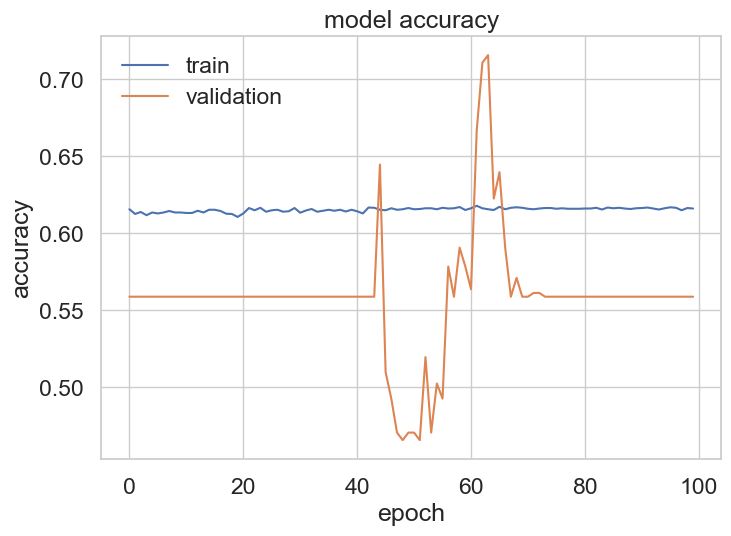

In [70]:
import matplotlib.pyplot as plt
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

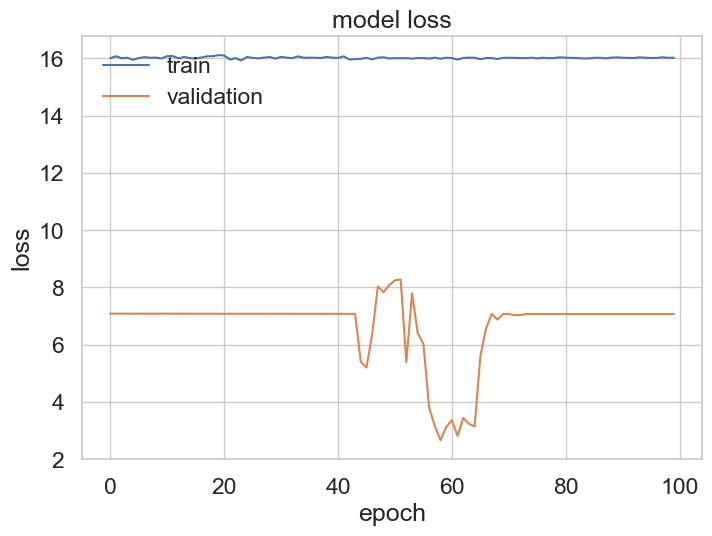

In [66]:
# "Loss"
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [67]:
stft_crepe_model.evaluate([test_stft_input, test_aug_stft_input, crepe_test_input],y_test_labels)

204/204 [==============================] - 1s 7ms/step


[7.072240829467773, 0.558823529996124]

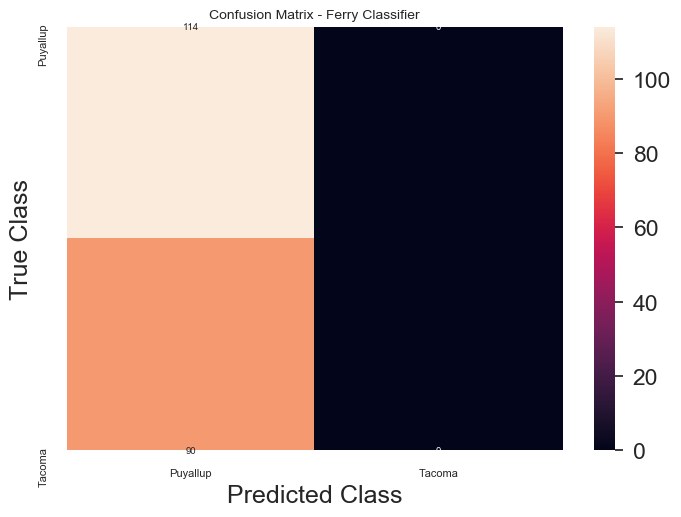

             precision    recall  f1-score   support

        0.0       0.56      1.00      0.72       114
        1.0       0.00      0.00      0.00        90

avg / total       0.31      0.56      0.40       204



C:\Users\pattyry\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [68]:
plt.style.use('default')
#plt.margins(1)
import matplotlib as mpl
import importlib
import matplotlib
import seaborn as sns

sns.set()
plt.style.use('seaborn')    
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})   

preds =np.argmax(stft_crepe_model.predict([test_stft_input, test_aug_stft_input, crepe_test_input]), axis=1)
cm = confusion_matrix(y_test.tolist(), preds.tolist())

sns.set(style="whitegrid", font_scale=1.5) 
akws = {"ha": 'center',"va": 'center', 'size':7}
ax = sns.heatmap(cm,  annot=True, fmt='d',annot_kws=akws)

ax.set_title('Confusion Matrix - Ferry Classifier', fontsize=10)
ax.xaxis.set_ticklabels(['Puyallup', 'Tacoma'], fontsize=8)
ax.yaxis.set_ticklabels(['Puyallup', 'Tacoma'], fontsize=8)
ax.set(xlabel='Predicted Class', ylabel='True Class')

    
plt.show()
print(classification_report(y_test.tolist(), preds.tolist()))

# The End